- iterate over the cells
- save hydrology and sediments
- make sure to save the ls, sc

1. Experiment 1: NO GLACIERS
2. Experiment 2: transport limited case (!!! HERE: calculate what is the mean annual sedimant yeild) 
3. Experiment 3: linear increase in sediment storage: (HOW BIG LANDSLIDE SHOULD BE?)

-- to make changes in the model go to run.py, SedCas_glacier_sed.py (model) or modules.py (modules)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt


# modelling part
from run import run


###  transport limited case (=sediment unlimited): calculate how much sediment there MAY be

In [ ]:
%%time
# climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangTL/default_land_cover'
# climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangTL/10percent_glacier'

# get all folders togetehr 
# ls_ = os.listdir('./langtang')
ls_ = os.listdir(climatepath)
ls = [d for d in ls_ if not d.startswith('.')]
dir0 = os.getcwd()

# run the model for each
for d in ls:
    # path = os.path.join(dir0, 'TL/default_land_cover', d)
    path = os.path.join(dir0, '1langtangTL/10percent_glacier', d)
    print(path)
    os.chdir(path)
    run()
    os.chdir(dir0)


# how much sediment is exported per year in the transport limited case (= unlimited amount of sedoments) ?

In [ ]:
# for each output sediment folder calculate the total annual 
# go over each folder 
# take Sediment out file 
# calculate annual mean
# save into the table, where the table has: cellnr, mean annual sed yeald

In [ ]:

# Define your custom function
def annual_sum_mean(df):
    df['D'] = pd.to_datetime(df['D'])
    df['Year'] = df['D'].dt.year
    annual_sum = df.groupby('Year').sum()
    annual_mean_Qstl = annual_sum.Qstl.mean()
    return annual_mean_Qstl

def annual_sum_percentile(df, percentile):
    df['D'] = pd.to_datetime(df['D'])
    df['Year'] = df['D'].dt.year
    annual_sum = df.groupby('Year').sum()
    annual_percentile_Qstl = annual_sum.Qstl.quantile(percentile / 100)
    return annual_percentile_Qstl


In [ ]:
%%time
# Path to the directory containing your folders
# directory_path = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangTL/default_land_cover'
directory_path = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangTL/10percent_glacier'

# an empty table to store results
mean_annual_sum = []
mean_annual_25 = []
mean_annual_50 = []
mean_annual_75 = []

# Iterate over each folder
for folder_name in os.listdir(directory_path):
    folder_path = os.path.join(directory_path, folder_name)
    
    # Check if it's a directory and its name starts with 'cellnr'
    if os.path.isdir(folder_path) and folder_name.startswith('cellnr'):
        # Locate the 'sediment.out' file within the folder
        sediment_out_path = os.path.join(folder_path, 'Sediment.out')
        
        # Read the contents of the file into a pandas DataFrame
        df = pd.read_csv(sediment_out_path, delimiter=',')  # Adjust delimiter if needed
        # mean:
        mean_annual_sum_value = annual_sum_mean(df)
        # percentiles:
        mean_annual_25_value = annual_sum_percentile(df, 25)
        mean_annual_50_value = annual_sum_percentile(df, 50)
        mean_annual_75_value = annual_sum_percentile(df, 75)

        
        # # Save the DataFrame into the results table
        # mean_annual_sum.append((int(folder_name.replace('cellnr', '')), mean_annual_sum_value))
        # mean_annual_25.append((int(folder_name.replace('cellnr', '')), mean_annual_25_value))
        # mean_annual_50.append((int(folder_name.replace('cellnr', '')), mean_annual_50_value))
        # mean_annual_75.append((int(folder_name.replace('cellnr', '')), mean_annual_75_value))

       # Save the DataFrame into the results table
        mean_annual_sum.append((folder_name.replace('cellnr', ''), mean_annual_sum_value))
        mean_annual_25.append((folder_name.replace('cellnr', ''), mean_annual_25_value))
        mean_annual_50.append((folder_name.replace('cellnr', ''), mean_annual_50_value))
        mean_annual_75.append((folder_name.replace('cellnr', ''), mean_annual_75_value))


# make table
mean_annual_sum_df = pd.DataFrame(mean_annual_sum, columns=['cellnr', 'annual_mean_Qstl_mm']).set_index('cellnr')
mean_annual_25_df = pd.DataFrame(mean_annual_25, columns=['cellnr', 'annual_25percent_Qstl_mm']).set_index('cellnr')#, inplace=True)
mean_annual_50_df = pd.DataFrame(mean_annual_50, columns=['cellnr', 'annual_50percent_Qstl_mm']).set_index('cellnr')#, inplace=True)
mean_annual_75_df = pd.DataFrame(mean_annual_75, columns=['cellnr', 'annual_75percent_Qstl_mm']).set_index('cellnr')#, inplace=True)

# merge together
merged_df = pd.concat([mean_annual_sum_df, mean_annual_25_df, mean_annual_50_df, mean_annual_75_df], axis=1)


In [ ]:
# mean_annual_sum_df['annual_mean_Qstl_m'] = mean_annual_sum_df.annual_mean_Qstl_mm/1000     # [sediments mm to m] 
# mean_annual_sum_df['annual_mean_Qstl_m3'] = mean_annual_sum_df.annual_mean_Qstl_m * 4.83*(10**6)   # [sediments [m] * area [m2]
# merged_df.sort_values(merged_df.index)

In [ ]:
for column in merged_df.columns:
    # for the columns with _mm in it
    if '_mm' in column:
        # Replace '_mm' with '_m3' and create a new column
        new_column_name = column.replace('_mm', '_m3')
        # convert to m3: 1) [sediments mm to m] 2) [sediments [m] * area [m2]
        merged_df[new_column_name] = (merged_df[column] / 1000) * 4.83 * (10 ** 6)
                

In [ ]:
# merged_df

## m3/day

In [ ]:
# Iterate over each column in the DataFrame
for column in merged_df.columns:
    if '_m3' in column:
        merged_df[column + '_day'] = merged_df[column] /365


In [ ]:
merged_df.head()



# add coordinates and save the output 

In [ ]:
# csv with coordinates and geopotential (z) 

coordinates = pd.read_csv('/Users/varyabazilova/Desktop/paper2/downscaling_simple/coordinates_with_labels_langtang.csv').set_index('cellnr2')
with_coords = pd.concat([merged_df, coordinates],  axis=1).reset_index()




In [ ]:
# len(with_coords)

In [ ]:
#save alltogether 
output_path = climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangTL/10percent_glacier/'
with_coords.to_csv(output_path + 'langtang_tl_10percent_glacier_percentiles_with_coords.csv', index = False)

In [ ]:
with_coords.columns

In [ ]:
columns_to_copy = ['cellnr', 'annual_mean_Qstl_m3_day', 'annual_25percent_Qstl_m3_day',
                   'annual_50percent_Qstl_m3_day', 'annual_75percent_Qstl_m3_day',
                   'Latitude_new', 'Longitude_new']

selected_columns= with_coords[columns_to_copy].copy()
                              

In [ ]:

selected_columns.to_csv(output_path + 'langtang_tl_10percent_glacier_percentiles_with_coords_m3_day.csv', index = False)

## transport limited case runs


/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr20a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr29a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr23a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr38a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr12b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr14a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr12d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr12c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr31a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr30b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr30d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr30c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr13a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr19a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr21c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr21d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr22b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr28b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr22d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr22c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr21b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...


/Users/varyabazilova/Desktop/paper2/202405_modelruns/SedCas_glacier_sed.py:221: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr28c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr28d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr23d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr23c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr20b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr29c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr29d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr20c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr20d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr23b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr29b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr31d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr12a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr31c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr14d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr38b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr14c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr31b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr14b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr38d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr38c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr19c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr19d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr13d
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr30a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr13c
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr19b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr13b
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr28a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr22a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


saving output...
/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent/cellnr21a
running sediment module...


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


saving output...
CPU times: user 24min 14s, sys: 6.82 s, total: 24min 21s
Wall time: 24min 26s


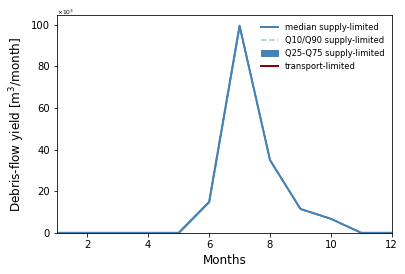

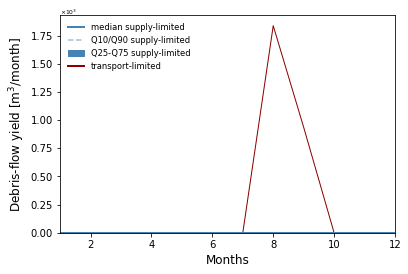

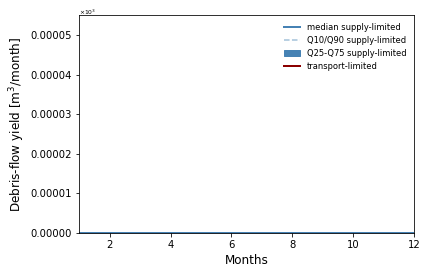

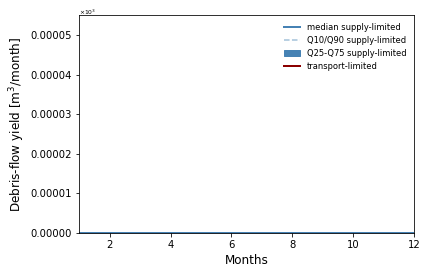

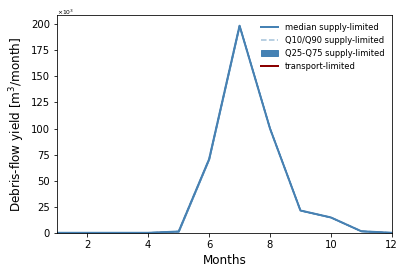

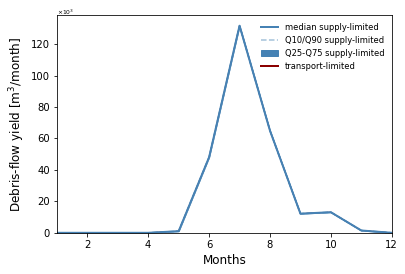

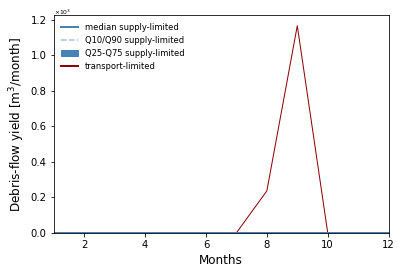

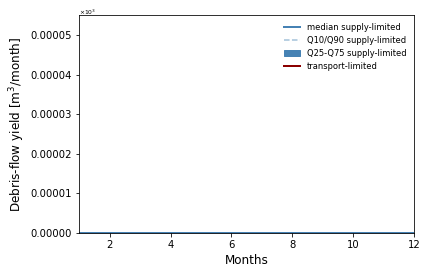

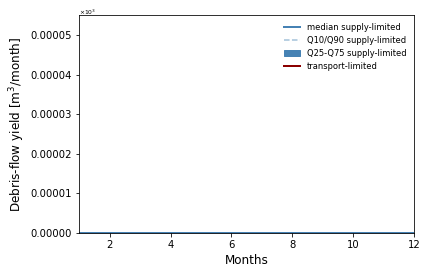

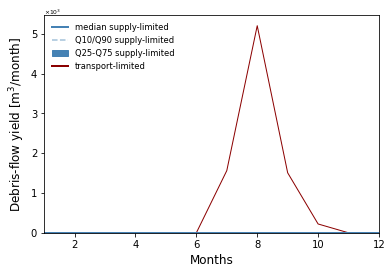

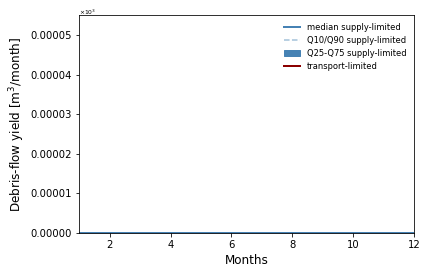

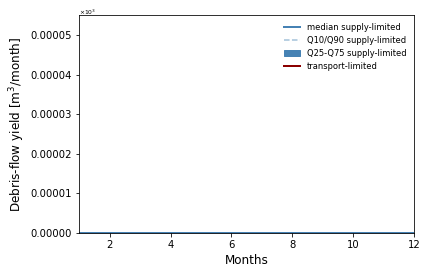

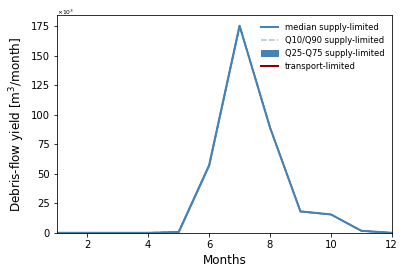

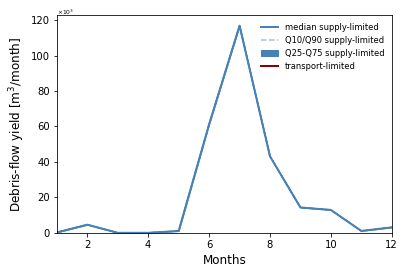

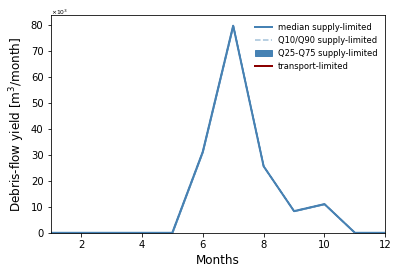

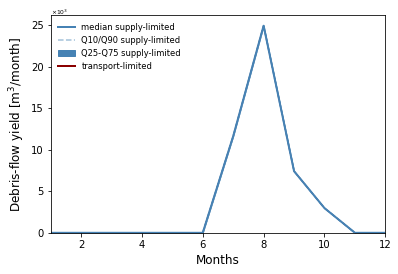

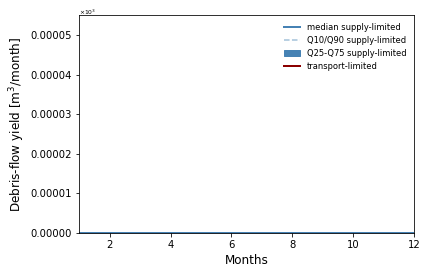

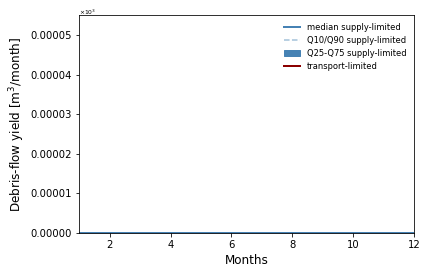

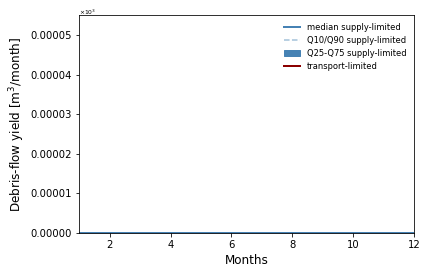

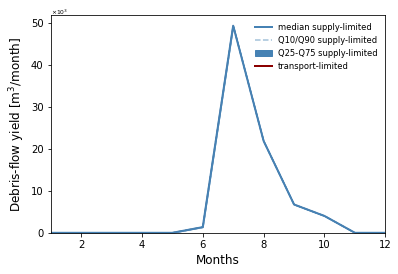

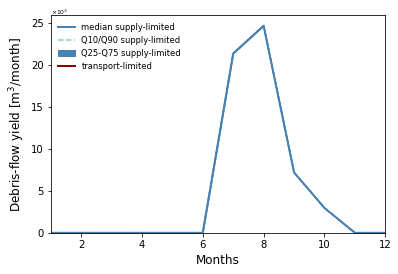

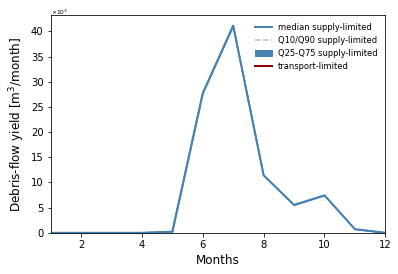

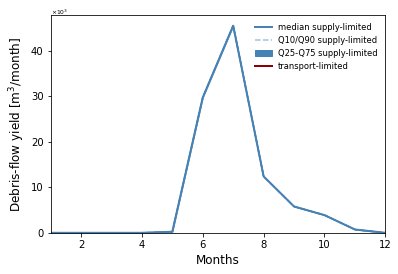

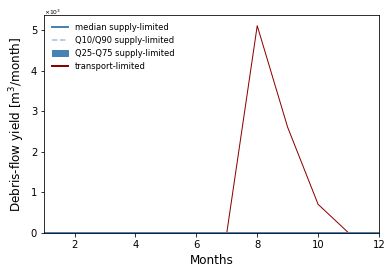

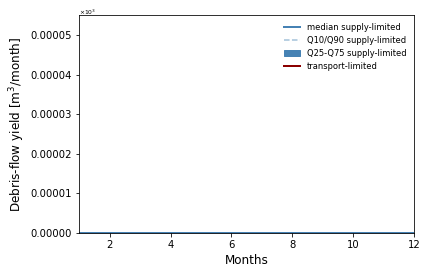

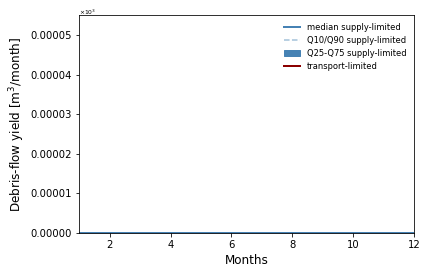

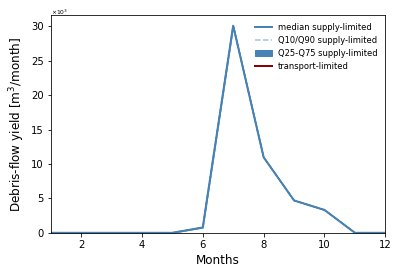

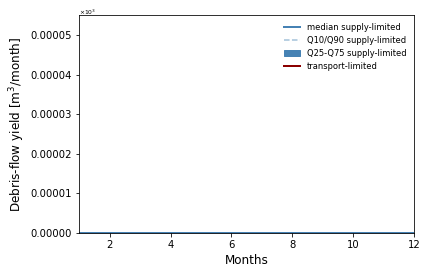

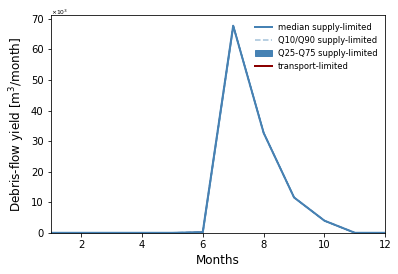

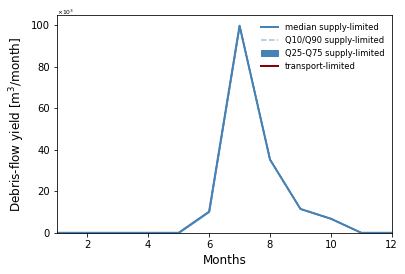

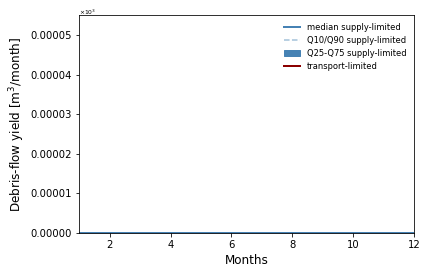

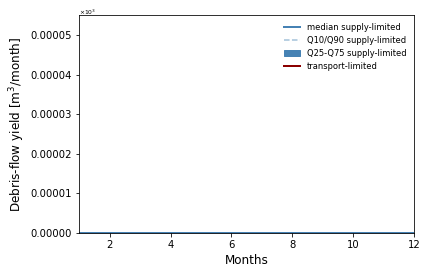

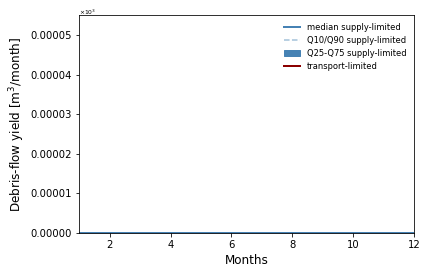

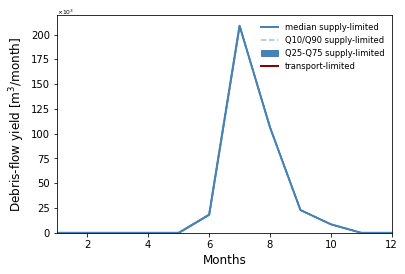

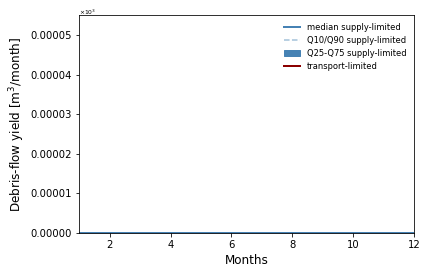

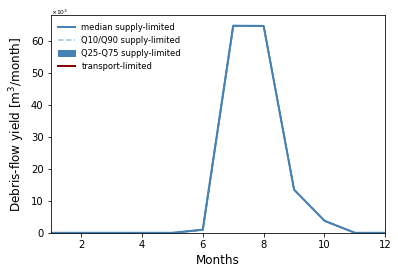

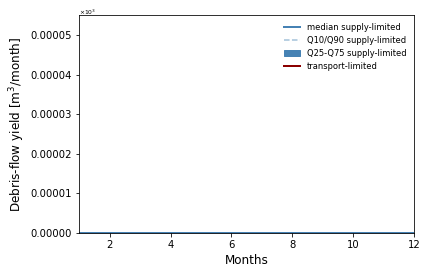

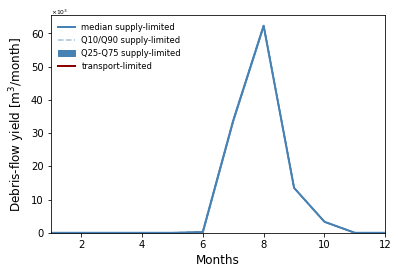

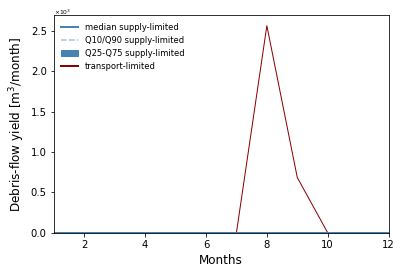

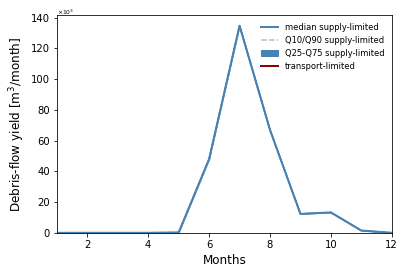

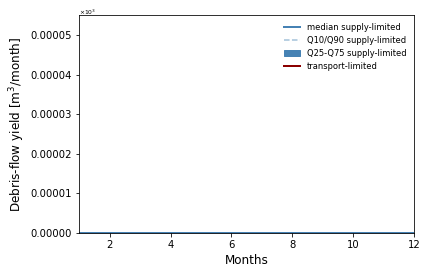

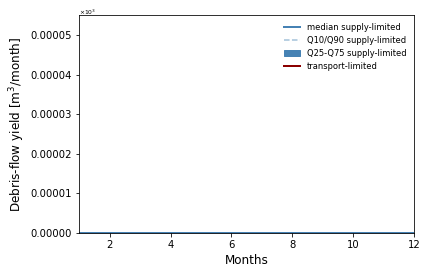

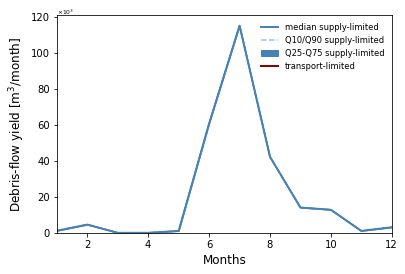

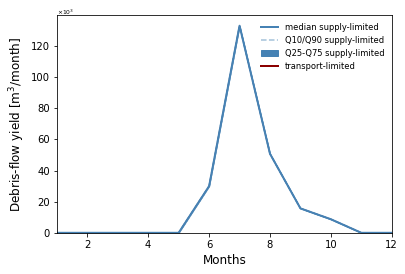

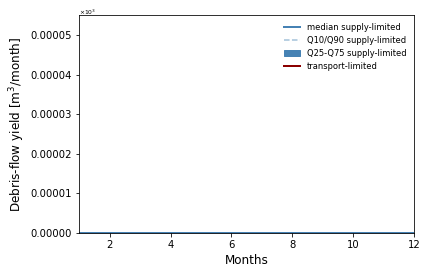

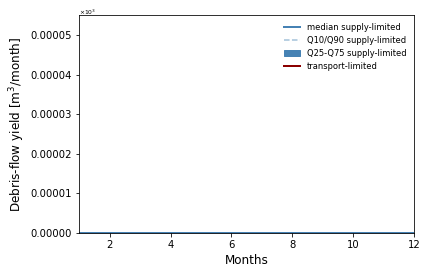

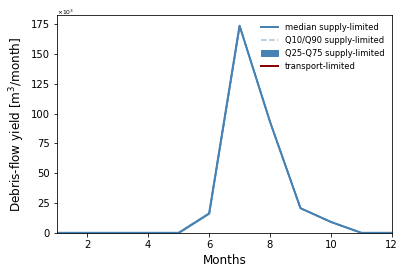

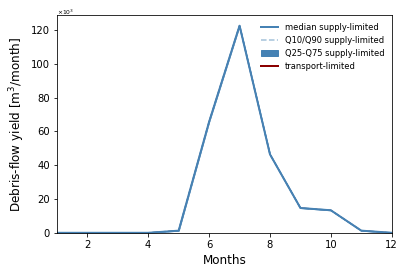

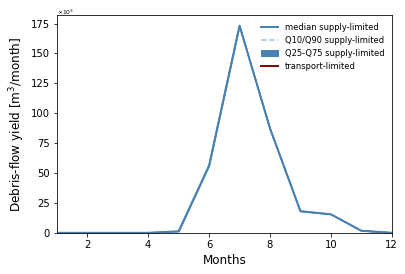

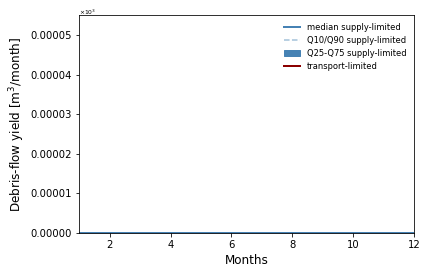

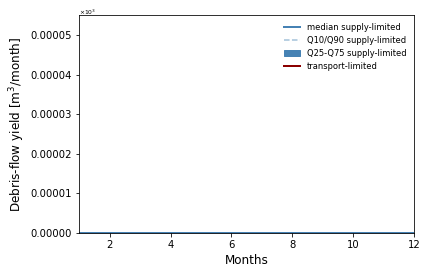

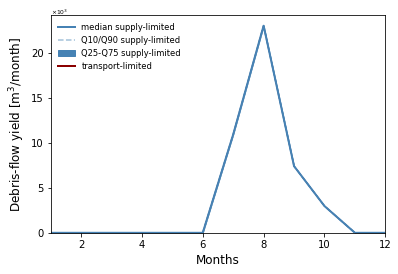

In [6]:
%%time
# climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangTL/default_land_cover'

# climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/default_land_cover/1default_land_cover_mean_annual'

# 10percent glacier cover
# climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/110percent_glacier_mean_annual'
# climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/210percent_glacier_25percent'
# climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/310percent_glacier_50percent'
climatepath = '/Users/varyabazilova/Desktop/paper2/202405_modelruns/1langtangSL/10percent_glacier/410percent_glacier_75percent'




# get all folders togetehr 
# ls_ = os.listdir('./langtang')
ls_ = os.listdir(climatepath)
ls = [d for d in ls_ if not d.startswith('.')]
dir0 = os.getcwd()

# run the model for each
for d in ls:
    # path = os.path.join(dir0, 'TL/default_land_cover', d)
    # path = os.path.join(dir0, '1langtangSL/default_land_cover/1default_land_cover_mean_annual', d)
    # path = os.path.join(dir0, '1langtangSL/default_land_cover/2default_land_cover_25percent', d)
    # path = os.path.join(dir0, '1langtangSL/default_land_cover/3default_land_cover_50percent', d)
    # path = os.path.join(dir0, '1langtangSL/default_land_cover/4default_land_cover_75percent', d)

    # 10percent glacier cover
    # path = os.path.join(dir0, '1langtangSL/10percent_glacier/110percent_glacier_mean_annual', d)
    # path = os.path.join(dir0, '1langtangSL/10percent_glacier/210percent_glacier_25percent', d)
    # path = os.path.join(dir0, '1langtangSL/10percent_glacier/310percent_glacier_50percent', d)
    path = os.path.join(dir0, '1langtangSL/10percent_glacier/410percent_glacier_75percent', d)
    print(path)
    os.chdir(path)
    run()
    os.chdir(dir0)


## 